# **Project: Predict Traffic Accidents in Flanders**
The goal of this notebook is to construct a model to predict the amount of traffic accidents per day, occurring in Flanders & Brussels, Belgium. 

**Setup: import of the necessary python libraries**

In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer, PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.datasets import make_regression
from sklearn import metrics

import xgboost as xgb
from xgboost import XGBRegressor

from prophet import Prophet

# Introduction

Every year, the Belgian government releases a full list of all traffic incidents that occurred in Belgium. 
In this notebook, I will construct a model that can help predict the expected number of accidents in a given day. 
I will limit our research to only the accidents that occurred in Flanders and Brussels. This is because certain features, such as traffic density statistics, were only available to me for these regions. 

#### The dataset 

The basis of our analysis will consist of an aggregated list of traffic accidents that occurred in Belgium in 2016, 2017 & 2018. We will filter out all accidents that did not occur in Flanders or Brussels. 
We will supplement this dataset with various other date- & weather related information: 

- Average traffic density per month 
- Total number of kilometers travelled per month 
- Average rainfall per month 
- Temperature per day 
- Indicators showing if a date falls in a weekend or on a national holiday 

See part 3 - Cleaning, for a full list of all features 

##### Models 

The used models are seperated in two different chapters: 

1. Descriptive models: the main goal here is to see if there are any interesting correlations between # of accidents per day and other information related to the same calendar date. These cannot be seen as predictive models in themselves however, as they contain information that cannot fully be known in advance, such as the average temperature per day. 

* Basic linear regression
* XGBoost
* Linear regression with rolling window


2. Predictive models: in this part, we will not use any features if we cannot know the value for future dates. 

* Time-series forecasting with Meta's Prophet 
* Basic linear regression

## Part 1: Getting the Target Variable 

Every year, the Belgian government releases a full list of all traffic incidents that occurred. 
We will download the lists for 2016, 2017 & 2018 and aggregate them by date. 
We will also filter out all incidents that occured in the Wallonia region. 

### Upload the incidents lists and merge them into one dataframe

First, we upload the lists and merge them into one dataframe. 

In [2]:
csv_files = glob.glob('Accidents/*.csv')
dataframes = [pd.read_csv(file, sep = ';') for file in csv_files]
data = pd.concat(dataframes, ignore_index=True)

data['DT_DAY'] = pd.to_datetime(data['DT_DAY'], infer_datetime_format=True)

data.head()

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_16640\1711521919.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['DT_DAY'] = pd.to_datetime(data['DT_DAY'], infer_datetime_format=True)
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_16640\1711521919.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['DT_DAY'] = pd.to_datetime(data['DT_DAY'], infer_datetime_format=True)


DT_DAY     TX_PROV_DESCR_NL
0 2016-08-04  Provincie Antwerpen
1 2016-11-29  Provincie Antwerpen
2 2016-11-14  Provincie Antwerpen
3 2016-12-18  Provincie Antwerpen
4 2016-08-05  Provincie Antwerpen

Next, we want to remove the provinces that are outside of Flanders. 

In [3]:
data['TX_PROV_DESCR_NL'].unique()

array(['Provincie Antwerpen', nan, 'Provincie West-Vlaanderen',
       'Provincie Oost-Vlaanderen', 'Provincie Henegouwen',
       'Provincie Luik', 'Provincie Limburg', 'Provincie Luxemburg',
       'Provincie Namen', 'Provincie Vlaams-Brabant',
       'Provincie Waals-Brabant'], dtype=object)

In [4]:
provinces_not_to_analyze = ['Provincie Henegouwen', 'Provincie Luik', 'Provincie Luxemburg', 
                        'Provincie Namen', 'Provincie Waals-Brabant']

data = data[~data['TX_PROV_DESCR_NL'].isin(provinces_not_to_analyze)]

data['TX_PROV_DESCR_NL'].unique()

array(['Provincie Antwerpen', nan, 'Provincie West-Vlaanderen',
       'Provincie Oost-Vlaanderen', 'Provincie Limburg',
       'Provincie Vlaams-Brabant'], dtype=object)

Some rows do not seem to contain a province. 
After checking the source data, I found out that these were accidents that happened in Brussels. 
Brussels is not part of any province. 
We will add Brussels as a separate "province".

In [5]:
data['TX_PROV_DESCR_NL'].fillna('Brussel', inplace=True)

Our dataframe is now ready to be aggregated. 
We will sum up the amount of accidents for every calendar date in our dataset.

In [6]:
# Rename the date column to "Date"
data.rename(columns={'DT_DAY': 'Date'}, inplace=True)

# Aggregate the number of accidents per day
data = data.groupby('Date').size().reset_index(name='Count')

data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1096 non-null   datetime64[ns]
 1   Count   1096 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 17.2 KB


Date        Count
count                 1096  1096.000000
mean   2017-07-01 12:00:00    75.708942
min    2016-01-01 00:00:00    17.000000
25%    2016-09-30 18:00:00    61.000000
50%    2017-07-01 12:00:00    75.000000
75%    2018-04-01 06:00:00    90.000000
max    2018-12-31 00:00:00   134.000000
std                    NaN    20.813899

In [7]:
data.head()

Date  Count
0 2016-01-01     54
1 2016-01-02     47
2 2016-01-03     54
3 2016-01-04     71
4 2016-01-05     69

data.info() confirms that we have 1096 different rows in our list and that they each have a value for "count". 

data.describe() shows us that the number of accidents lies between 17 & 134, with a mean value of 75.71

## Part 2: Adding Features

We have multiple files available with features that could be relevant in predicting the number of accidents. 
We will merge each of them with our current dataset.

First we add the average amount of rainfall per day. Next we will merge this file with our traffic data.

In [8]:
rainfall = pd.read_csv("Features/Neerslag_2016_to_2019.csv", 
                       sep='\t')

rainfall['Date'] = pd.to_datetime(rainfall['Date'], format='%d/%m/%Y')
rainfall.info()
#note: I tried to get rid of the warning messages, but nothing worked and I eventually gave up.                     

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 1096 non-null   datetime64[ns]
 1   neerslaghoeveelheid  1096 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 17.2+ KB


In [9]:
data = pd.merge(data, rainfall, on='Date')

We will do the same for the temperature data.
This file contains the min. & max. temperature per day measured in Ukkel, Belgium.

I also added two new columns: 

'Frost': is the min. temp for that day lower than 0°C? 

'General_frost': is the max. temp for that day lower than 0°C?

In [10]:
temperature = pd.read_csv("Features/Temp_2016_to_2019.csv", 
                           sep =';')
temperature['Date'] = pd.to_datetime(temperature['Date'], format='%d/%m/%Y')
data = pd.merge(data, temperature, on='Date')

We also have a statistic on how much traffic overload ("filezwaarte") there is in Flanders. 
However, we only have averages per month, so we will have to add columns "day", 
"month" & "year" to our Dataframe in order to merge this data. 


In [11]:
data['day_of_month'] = data['Date'].dt.day
data['month_of_year'] = data['Date'].dt.month 
data['year'] = data['Date'].dt.year 

filezwaarte = pd.read_csv("Features/filezwaarte_20230417221127.csv", 
                            sep =';')
data = pd.merge(data, filezwaarte, left_on=['year', 'month_of_year'], right_on=['Jaar', 'Maand'])

We have a second traffic statistic, the "verkeersprestatie", which displays the amount of kilometers travelled on Flanders' roads each month.


In [12]:
verkeersprestatie = pd.read_csv("Features/verkeersprestatie_20230417221607.csv", 
                           sep =';')
data = pd.merge(data, verkeersprestatie, left_on=['year', 'month_of_year'], right_on=['Jaar', 'Maand'])

Next feature source is the average amount of daylight (in hours) per day. 
I only found this measure for the year 2016. 
We will generalize them so that we also have numbers for 2017 & 2018.
Please note that sunrise & sunset do not fall on the exact same time each year. 
However, for our purposes, the difference will be small enough to ignore. 

In [13]:
daylight = pd.read_csv("Features/Uren_zon_per_dag.csv", 
                           sep =';')
data = pd.merge(data, daylight, left_on=['month_of_year', 'day_of_month'], right_on=['Maand', 'Dag'])

Next feature is a list of all public holidays in Belgium. 
We create a new column "Holiday" that will show us if a certain date was a national holiday.

In [14]:
holidays = pd.read_csv("Features/Feestdagen_2016_to_2021.csv", 
                           parse_dates=['Date'], infer_datetime_format=True, sep =';')

data['Holiday'] = data['Date'].isin(holidays['Date'])

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_16640\3352373661.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  holidays = pd.read_csv("Features/Feestdagen_2016_to_2021.csv",
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_16640\3352373661.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  holidays = pd.read_csv("Features/Feestdagen_2016_to_2021.csv",


Finally, let's also add one more column that tells us if the date falls on a weekday (=0) or a weekend (=1)

In [15]:
data['is_weekend'] = data['Date'].apply(lambda x: 1 if x.dayofweek >= 5 else 0)

data.head()

Date  Count neerslaghoeveelheid Max. temp. min. Temp. Frost  \
0 2016-01-01     54                 2,2        7,1        3,4    No   
1 2017-01-01     42                 3,6       -0,1       -3,4   Yes   
2 2018-01-01     48                 6,9        7,2        5,1    No   
3 2016-01-02     47                   9       10,9        2,9    No   
4 2017-01-02     44                 0,2        0,6       -4,4   Yes   

  General_frost  day_of_month  month_of_year  year  ...     Vtgkm  dagmaand  \
0            No             1              1  2016  ...  54285457    01-Jan   
1           Yes             1              1  2017  ...  54323683    01-Jan   
2            No             1              1  2018  ...  57056203    01-Jan   
3            No             2              1  2016  ...  54285457    02-Jan   
4            No             2              1  2017  ...  54323683    02-Jan   

  Dag Maand    opgang  ondergang      date      Column1  Holiday is_weekend  
0   1     1  08:47:00   16:39:00  07:52:00  0,327777778     True          0  
1   1     1  08:47:00   16:39:00  07:52:00  0,327777778     True          1  
2   1     1  08:47:00   16:39:00  07:52:00  0,327777778     True          0  
3   2     1  08:47:00   16:40:00  07:53:00  0,328472222    False          1  
4   2     1  08:47:00   16:40:00  07:53:00  0,328472222    False          0  

[5 rows x 28 columns]

## PART 3: Cleaning
Before we can analayze, there a few things we can do to clean up our dataframe.

First, let's isolate only the columns that are relevant for our analysis. 
We will also rename some columns for easier recognition.

In [16]:
column_names = data.columns
print(column_names) 

Index(['Date', 'Count', 'neerslaghoeveelheid', 'Max. temp.', 'min. Temp.',
       'Frost', 'General_frost', 'day_of_month', 'month_of_year', 'year',
       'Jaar_x', 'Maand_x', 'RA omschrijving_x', 'Gemiddelde (km.uren)',
       'Voortschrijdend gemiddelde (km.uren)', 'Jaar_y', 'Maand_y',
       'RA omschrijving_y', 'Vtgkm', 'dagmaand', 'Dag', 'Maand', 'opgang',
       'ondergang', 'date', 'Column1', 'Holiday', 'is_weekend'],
      dtype='object')


In [17]:
data = data[['Date', 'Count', 'neerslaghoeveelheid', 'Max. temp.', 'min. Temp.', 'Frost', 'General_frost', 'Gemiddelde (km.uren)', 
           'Vtgkm', 'Column1', 'Holiday', 'is_weekend']]

data.rename(columns={'Count': 'Number_of_accidents', 'Gemiddelde (km.uren)': 'Monthly_traffic_density', 
                     'Vtgkm': 'Monthly_kilometers_travelled', 'Column1': 'Daylight_percentage', 
                    'neerslaghoeveelheid': 'Average_rainfall_month'}, inplace=True)

data.head()

Date  Number_of_accidents Average_rainfall_month Max. temp.  \
0 2016-01-01                   54                    2,2        7,1   
1 2017-01-01                   42                    3,6       -0,1   
2 2018-01-01                   48                    6,9        7,2   
3 2016-01-02                   47                      9       10,9   
4 2017-01-02                   44                    0,2        0,6   

  min. Temp. Frost General_frost Monthly_traffic_density  \
0        3,4    No            No                  465,33   
1       -3,4   Yes           Yes                  375,96   
2        5,1    No            No                  402,75   
3        2,9    No            No                  465,33   
4       -4,4   Yes            No                  375,96   

   Monthly_kilometers_travelled Daylight_percentage  Holiday  is_weekend  
0                      54285457         0,327777778     True           0  
1                      54323683         0,327777778     True           1  
2                      57056203         0,327777778     True           0  
3                      54285457         0,328472222    False           1  
4                      54323683         0,328472222    False           0

Some columns contain strings or boolean values. Let's convert them to integers.

In [18]:
data['Holiday'] = data['Holiday'].astype(int)
data['Frost'] = data['Frost'].replace({'Yes': 1, 'No': 0})
data['General_frost'] = data['General_frost'].replace({'Yes': 1, 'No': 0})

data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          1096 non-null   datetime64[ns]
 1   Number_of_accidents           1096 non-null   int64         
 2   Average_rainfall_month        1096 non-null   object        
 3   Max. temp.                    1096 non-null   object        
 4   min. Temp.                    1096 non-null   object        
 5   Frost                         1096 non-null   int64         
 6   General_frost                 1096 non-null   int64         
 7   Monthly_traffic_density       1096 non-null   object        
 8   Monthly_kilometers_travelled  1096 non-null   int64         
 9   Daylight_percentage           1096 non-null   object        
 10  Holiday                       1096 non-null   int32         
 11  is_weekend                    

Some columns are recognized as objects, some as integers. 
To avoid any issues, I converted all of them to floats. 

Ofcourse we have to exclude the "Date" column from this transformation.

In [19]:
data_date = data['Date']
data = data.drop('Date', axis=1)

data = data.replace(',', '.', regex=True)
data = data.astype(float)

data = data.join(data_date)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Number_of_accidents           1096 non-null   float64       
 1   Average_rainfall_month        1096 non-null   float64       
 2   Max. temp.                    1096 non-null   float64       
 3   min. Temp.                    1096 non-null   float64       
 4   Frost                         1096 non-null   float64       
 5   General_frost                 1096 non-null   float64       
 6   Monthly_traffic_density       1096 non-null   float64       
 7   Monthly_kilometers_travelled  1096 non-null   float64       
 8   Daylight_percentage           1096 non-null   float64       
 9   Holiday                       1096 non-null   float64       
 10  is_weekend                    1096 non-null   float64       
 11  Date                          

Looking good! 
There are no null values and all columns have the correct datatype. 

Let's check if there are any outliers: 

In [20]:
data.describe()

Number_of_accidents  Average_rainfall_month   Max. temp.   min. Temp.  \
count          1096.000000             1096.000000  1096.000000  1096.000000   
mean             75.708942                2.128376    15.123996     7.457117   
min              17.000000                0.000000    -2.200000    -8.700000   
25%              61.000000                0.000000     8.800000     3.100000   
50%              75.000000                0.000000    14.700000     7.200000   
75%              90.000000                2.300000    21.400000    12.600000   
max             134.000000               36.700000    35.400000    21.400000   
std              20.813899                4.371285     7.650090     5.967639   

             Frost  General_frost  Monthly_traffic_density  \
count  1096.000000    1096.000000              1096.000000   
mean      0.110401       0.010036               551.714443   
min       0.000000       0.000000               352.990000   
25%       0.000000       0.000000               465.330000   
50%       0.000000       0.000000               546.680000   
75%       0.000000       0.000000               621.620000   
max       1.000000       1.000000               803.200000   
std       0.313533       0.099724               111.875639   

       Monthly_kilometers_travelled  Daylight_percentage      Holiday  \
count                  1.096000e+03          1096.000000  1096.000000   
mean                   6.003111e+07             0.511171     0.031934   
min                    5.428546e+07             0.322222     0.000000   
25%                    5.869025e+07             0.388889     0.000000   
50%                    6.110179e+07             0.511806     0.000000   
75%                    6.217090e+07             0.634028     0.000000   
max                    6.339586e+07             0.697222     1.000000   
std                    2.607380e+06             0.127689     0.175905   

        is_weekend                 Date  
count  1096.000000                 1096  
mean      0.286496  2017-07-01 12:00:00  
min       0.000000  2016-01-01 00:00:00  
25%       0.000000  2016-09-30 18:00:00  
50%       0.000000  2017-07-01 12:00:00  
75%       1.000000  2018-04-01 06:00:00  
max       1.000000  2018-12-31 00:00:00  
std       0.452330                  NaN

To see how the data is distributed, we can also make a histogram for all features in the list: 

In [21]:
column_names = data.columns
print(column_names) 

Index(['Number_of_accidents', 'Average_rainfall_month', 'Max. temp.',
       'min. Temp.', 'Frost', 'General_frost', 'Monthly_traffic_density',
       'Monthly_kilometers_travelled', 'Daylight_percentage', 'Holiday',
       'is_weekend', 'Date'],
      dtype='object')


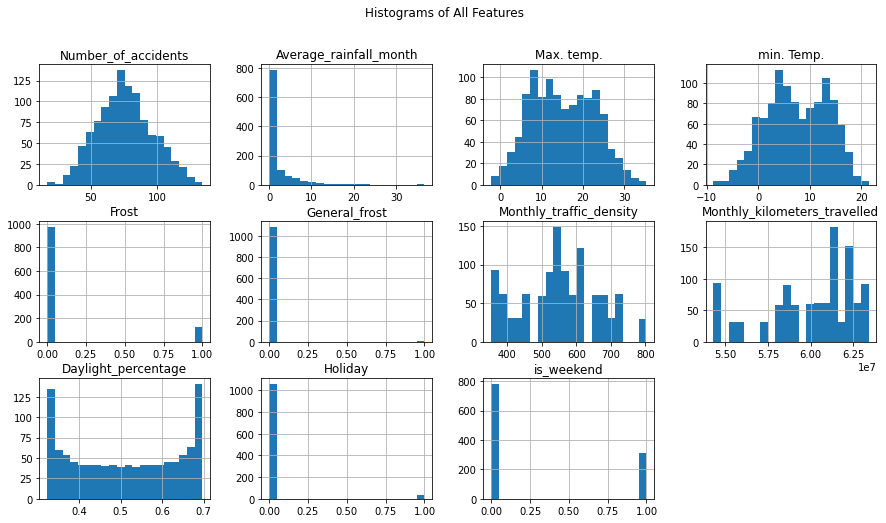

In [22]:
columns = ['Number_of_accidents', 'Average_rainfall_month', 'Max. temp.',
       'min. Temp.', 'Frost', 'General_frost', 'Monthly_traffic_density',
       'Monthly_kilometers_travelled', 'Daylight_percentage', 'Holiday',
       'is_weekend']

# Plot the histograms
data[columns].hist(bins=20, figsize=(15, 8), layout=(3, 4))

# Add title and show the plot
plt.suptitle("Histograms of All Features")
plt.show()

The number of accidents seems to follow a normal distribution. 
We will check this just to be sure, using a Q-Q plot. 

As you can see below, the datapoints seem to roughly follow the "x=y"-line. 
This suggests that our target variable indeed follows a normal distribution. 

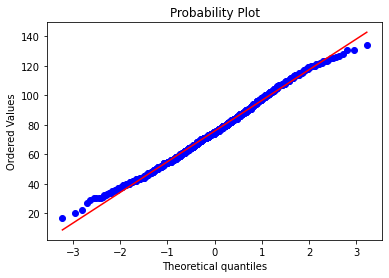

In [23]:
stats.probplot(data['Number_of_accidents'], plot=plt)
plt.show()

**Min. & Max. temp** approximate a bimodal distribution. 
In countries with well-defined winter and summer seasons, it's normal for the temperature to have two peaks.

Over 1096 days, **frost** only occured on 121 separate days. 
There were only 11 days where it froze throughout the whole day. 

The **daylight percentage** seems to have a U-shaped distribution. 
We will have to explore this further, to make sure that this is correct. 

**Holiday & is_weekend** are distributed as expected.

**Monthly_traffic_density** and **Monthly_kilometers_travelled** both have a very uneven distribution. 
As we are limited to monthly averages for these features, the amount of unique datapoints is very limited. 

In [24]:
Monthly_traffic_density_unique = data['Monthly_traffic_density'].nunique()
Monthly_kilometers_travelled_unique = data['Monthly_kilometers_travelled'].nunique()
print (f"Amount of unique values for monthly traffic density: {Monthly_traffic_density_unique}")
print (f"Amount of unique values for monthly kilometers travelled: {Monthly_kilometers_travelled_unique}")

Amount of unique values for monthly traffic density: 36
Amount of unique values for monthly kilometers travelled: 36


#### Daylight percentage: does the distribution make sense? 
Let's plot the daylight percentage for one entire year (2016), to see if it follows a natural pattern.

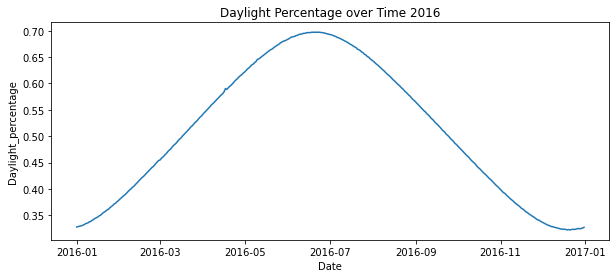

In [25]:
data_2016 = data[data['Date'].dt.year == 2016]

plt.figure(figsize=(10, 4))  
plt.plot(data_2016['Date'], data_2016['Daylight_percentage'])
plt.xlabel('Date')
plt.ylabel('Daylight_percentage')
plt.title('Daylight Percentage over Time 2016')

# Show the figure
plt.show()

Conclusion: this looks correct. We have a peak in the summer towards the end of June. De shortest day of the year is around the end of December. 
*Note: all plots are the exact same because we are actually cheating a bit, by re-using the same data every year for daylight percentage. 

## Part 4: Exploratory Data Analysis

We already did quite some data exploration in previous chapters. 
What's still missing is a good view on how our features are correlated with the target. 

For this purpose I created a correlation matrix & displayed it in a heatmap. 

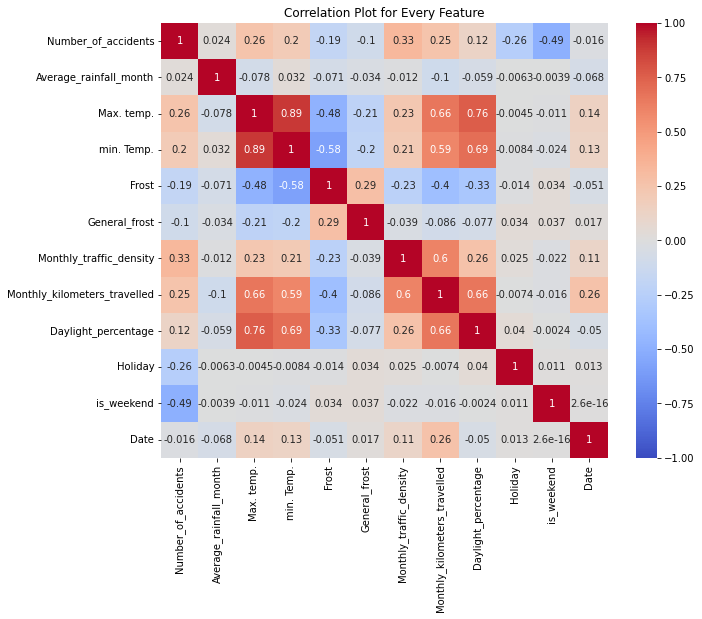

In [26]:
corr_matrix = data.corr()
corr_matrix.head()

plt.figure(figsize=(10, 8)) # Adjust the figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Plot for Every Feature')
plt.show()


As you can see the most significant correlation is found with the category "is_weekend". 
This makes sense. As roads are usually less crowded on weekends, we can expect a big negative correlation there. 

The "average monthly traffic density" also shows a significant correlation (0.33) 

The "average monthly kilometers travelled" displays a slightly smaller significance (0.25), 
suggesting that road activity has less impact on the number of accidents if the road activity is more evenly distributed. However, since we are restricted to using monthly averages, we might not have enough samples to confidently state this. 

Surprisingly, freezing temperatures have a negative impact on the number of traffic accidents(!)

In [27]:
frost_days = data['Frost'].sum()
general_frost_days = data['General_frost'].sum()

print(f"Amount of days with freezing temperatures: {frost_days}")
print(f"Amount of days where the max. temp. does not exceed 0°C: {general_frost_days}")

Amount of days with freezing temperatures: 121.0
Amount of days where the max. temp. does not exceed 0°C: 11.0


There are 121 days with freezing temperatures in our dataset. Due to the weak correlation, it may still be accidental. 

Another explanation could be the fact that freezing temperatures correlate with another variable in- or outside of our dataset.

**Correlation does not equal causation** - Corneel Van Eykeren, 2023

However, there seem to be no strong correlations between "frost" and any other variable that is not related to temperature. 

Does the amount of accidents somehow decrease during the winter months? 
Let's check this just to be sure: 


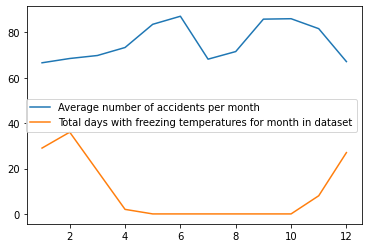

In [28]:
monthly_data = data.groupby([data['Date'].dt.month])['Number_of_accidents'].mean()

monthly_frost = data.groupby([data['Date'].dt.month])['Frost'].sum()

plt.plot(monthly_data, label='Average number of accidents per month')
plt.plot(monthly_frost, label='Total days with freezing temperatures for month in dataset')

plt.legend()

There are two main peaks in the number of accidents. 
The first one falls in May/June, the second around September/Oktober. 
Let's see how this compares with the average traffic density per month: 

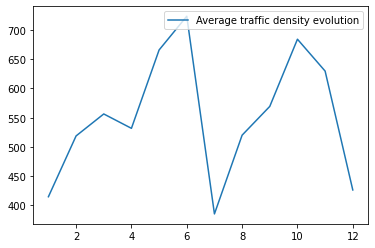

In [29]:
monthly_data = data.groupby([data['Date'].dt.month])['Monthly_traffic_density'].mean()
plt.plot(monthly_data, label='Average traffic density evolution')
plt.legend()

As stated there are two obvious peaks in traffic density. 
These peaks fall outside of the coldest months. 
We will not explore this further here, but it would be interesting for further analysis. 

## Part 5: Machine Learning - Descriptive Analytics

I divided the "Machine Learning" section of this notebook into two parts. 

In this part, we will use all features available to try and train a reliable model. 
However, some of those features, like weather data & traffic statistics, are not known in advance. 
The models in this chapter will mainly provide us with a useful descriptive analysis. 
It would be unfair to label them as predictive models. 

### Basic Linear Regression

First, let's try the basic Linear Regression Model by scikit-learn

In [30]:
# As we are working with time-dependent data, it's important to sort our observations by date.
data = data.sort_values('Date', ascending=True) 

X = data.drop(['Number_of_accidents', 'Date'], axis=1)
y = data['Number_of_accidents']

# Make sure not to shuffle our dataset, as this can cause data leakage.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# calculate the metrics
mse_dlr = metrics.mean_squared_error(y_test, y_pred)
mae_dlr = metrics.mean_absolute_error(y_test, y_pred)
r2_dlr = metrics.r2_score(y_test, y_pred)

print('Mean Squared Error:', mse_dlr)
print('Mean Absolute Error:', mae_dlr)
print('R^2 Score:', r2_dlr)

Mean Squared Error: 253.6979331127426
Mean Absolute Error: 12.704332271393888
R^2 Score: 0.4768364774565227


We get an R2-score of 0.48, which means the model is able to explain about 48% of the variation in the data. 
This is a significant result, but there is still a lot of room for improvement. 

The plot of our predicted vs. actual values may give us some more insight.

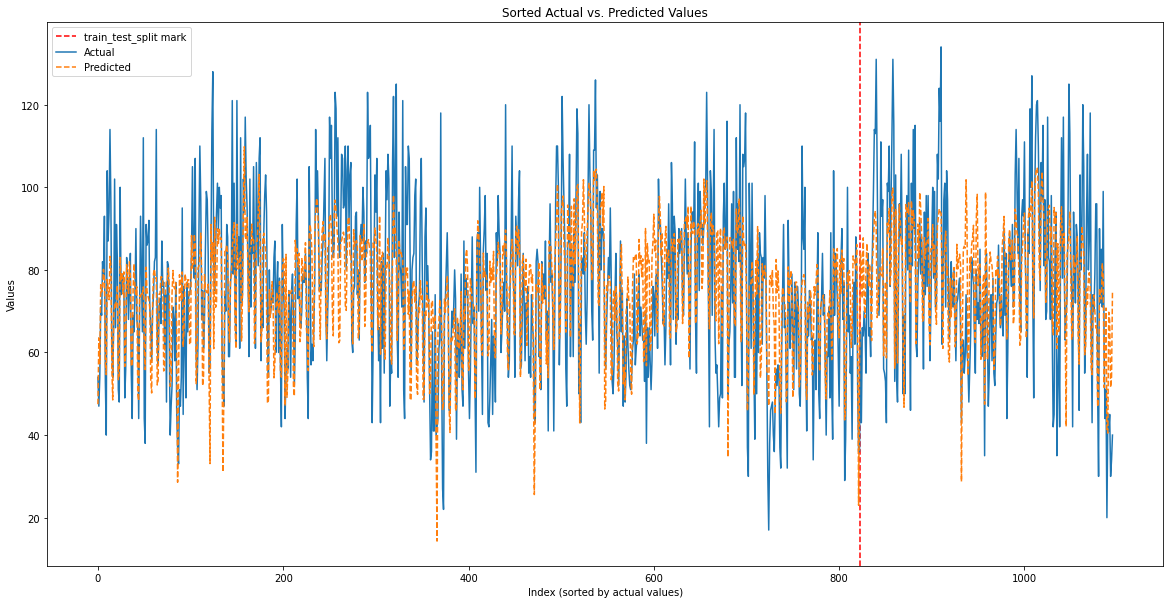

In [31]:
y_pred_all = model.predict(X)

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({'Actual': y, 'Predicted': y_pred_all})

#Prepare a line to distinguish trainset & testset
train_test_split_mark = int(len(y) * 0.75)

# Create a line plot to compare sorted actual and predicted values
plt.figure(figsize=(20, 10))
plt.axvline(x=train_test_split_mark, color='r', linestyle='--', label='train_test_split mark')
plt.plot(results_df['Actual'].reset_index(drop=True), label='Actual')
plt.plot(results_df['Predicted'].reset_index(drop=True), label='Predicted', linestyle='--')
plt.xlabel('Index (sorted by actual values)')
plt.ylabel('Values')
plt.title('Sorted Actual vs. Predicted Values')
plt.legend()

plt.show()

The model is able to "predict" some general trends in our data. 
It seems to mainly break down when dealing with positive outliers. 

When we zoom in to the data for 2017, we get a better view of this: 

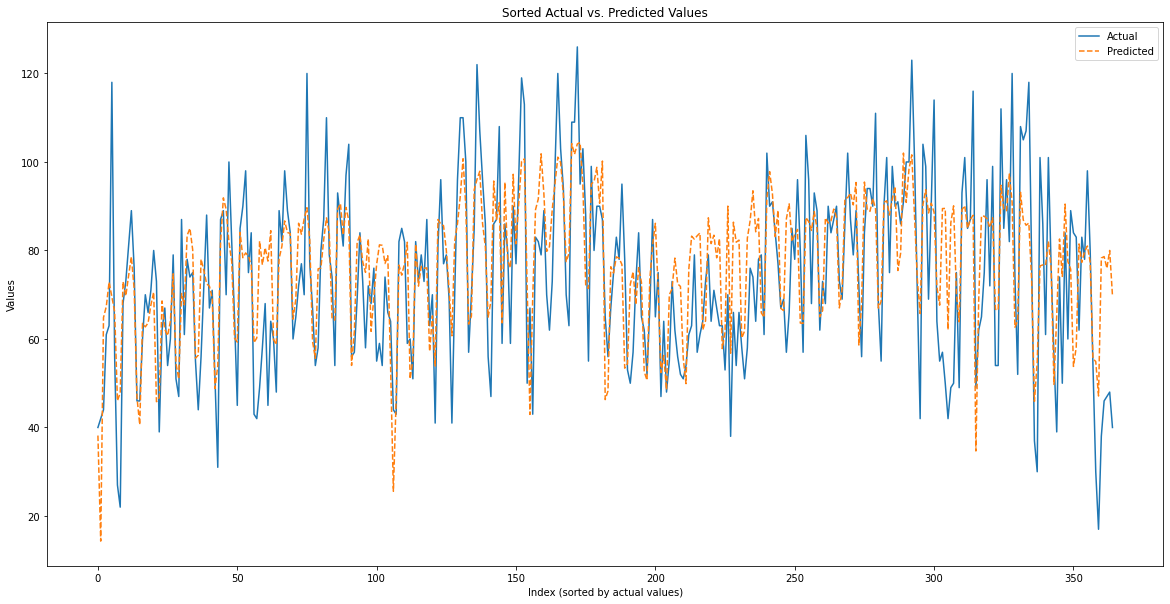

In [32]:
y_pred_2017 = model.predict(X[365:730])

y_2017 = y[365:730]
# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({'Actual': y_2017, 'Predicted': y_pred_2017})

# Create a line plot to compare sorted actual and predicted values
plt.figure(figsize=(20, 10))
plt.plot(results_df['Actual'].reset_index(drop=True), label='Actual')
plt.plot(results_df['Predicted'].reset_index(drop=True), label='Predicted', linestyle='--')
plt.xlabel('Index (sorted by actual values)')
plt.ylabel('Values')
plt.title('Sorted Actual vs. Predicted Values')
plt.legend()

plt.show()

On closer inspection, it seems that outliers in both direction are often underestimated by the model. 

It might also be wise to check if the model if overfitting to out training set in some way. 
For this we can evaluate the metrics on the training set instead of the testset. 

In [33]:
y_pred_train = model.predict(X_train)

# calculate the metrics
mse = metrics.mean_squared_error(y_train, y_pred_train)
mae = metrics.mean_absolute_error(y_train, y_pred_train)
r2 = metrics.r2_score(y_train, y_pred_train)

print('Mean Squared Error - training set:', mse)
print('Mean Absolute Error - training set:', mae)
print('R^2 Score: - training set', r2)

Mean Squared Error - training set: 219.56004674120527
Mean Absolute Error - training set: 11.766437980120402
R^2 Score: - training set 0.46752141088372745


The evaluation is comparable, except for the fact that the Mean Squared Error is a bit higher for the test set. 
This indicates a higher sensitivity to outliers. 

Looking at the graph however, we see higher peaks in our testset, so this is not unexpected. 

The model seems to be fairly robust. 

### Polynomials + XGBoost

For our third try, we make the following changes: 

1. Swap the CBPoissonRegressor with XGBoost
2. Create a grid with different parameters that may reduce overfitting
3. Add polynomial features 

XGBoost, short for "Extreme Gradient Boosting", is an optimized distributed gradient boosting library. It's based on the Gradient Boosting framework, which creates a prediction model in the form of an ensemble of weak prediction models, typically decision trees.

In [34]:
# As we are working with time-dependent data, it's important to sort our observations by date.
data = data.sort_values('Date', ascending=True) 

X = data.drop(['Number_of_accidents', 'Date'], axis=1)
y = data['Number_of_accidents']

We will experiment with the following parameters, to get an accurate model while at the same time avoiding overfitting out data: 

**eta [default=0.3, alias: learning_rate]**

Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.

**range: [0,1]**

eta [default=0.3, alias: learning_rate]

Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.

**lambda [default=1, alias: reg_lambda]**

L2 regularization term on weights. Increasing this value will make model more conservative.

**Note:** Due to CPU constraints, I had to tinker a bit here. 

After running RandomizedSearchCV a couple of times, I found wildly varying values for lambda & learning rate. 

Eta, gamma & max_depth however, always showed the same values. 

I adjusted the grid accordingly. On the plus side, this change allows me to test more values for lambda & learning rate.


Original grid:

hyperparameter_grid = {

    'eta': [0.01, 0.1, 0.3],'gamma': [0, 0.1, 0.2],
    
    'lambda': np.logspace(-2, 0, 50),
    
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2, 0.3],
    
    'max_depth': [4, 5, 6],}
    

"Optimized" grid:


hyperparameter_grid = {

    'lambda': np.logspace(-2, 0, 50),
    
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2, 0.3],
    
    }

In [35]:
# add polynomial features 
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# convert the result back to a DataFrame
X_poly = pd.DataFrame(X_poly)
# create column names for polynomials
column_names = poly.get_feature_names_out(input_features=X.columns)
X_poly.columns = column_names

# Scale the features
scaler = StandardScaler()
X_poly = scaler.fit_transform(X_poly)

# Normalize the features
scaler = Normalizer()
X_poly = scaler.fit_transform(X_poly)
X_poly = pd.DataFrame(X_poly, columns=column_names)

# Clip values beyond a certain treshold. This avoids errors when fitting the model. 
X_poly = X_poly.clip(-1e11,1e11)

# Make sure not to shuffle our dataset, as this can cause data leakage.
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.25, shuffle=False)

regressor=xgb.XGBRegressor(eval_metric='rmse')

# set up our search grid
hyperparameter_grid = {
    'lambda': np.logspace(-2, 0, 50),
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2, 0.3],
    }

# try out every combination of the above values
search = GridSearchCV(regressor, hyperparameter_grid, cv=3).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_) 

The best hyperparameters are  {'lambda': 0.3906939937054615, 'learning_rate': 0.05}


In [36]:
regressor=xgb.XGBRegressor(eta = 0.1,
                           gamma  = 0,
                           reg_lambda = search.best_params_["lambda"],
                           learning_rate = search.best_params_["learning_rate"],
                           max_depth = 4,
                           eval_metric='rmse')

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

# calculate the metrics
mse_dxgb = metrics.mean_squared_error(y_test, y_pred)
mae_dxgb = metrics.mean_absolute_error(y_test, y_pred)
r2_dxgb = metrics.r2_score(y_test, y_pred)

print('Mean Squared Error:', mse_dxgb)
print('Mean Absolute Error:', mae_dxgb)
print('R^2 Score:', r2_dxgb)

Mean Squared Error: 268.1362389819987
Mean Absolute Error: 12.98731330537448
R^2 Score: 0.44706250624027555


Unfortunately, we have not yet been able to improve on our most basic linear regression model. 

A plot of the predicted/actual features will hopefully show us why: 

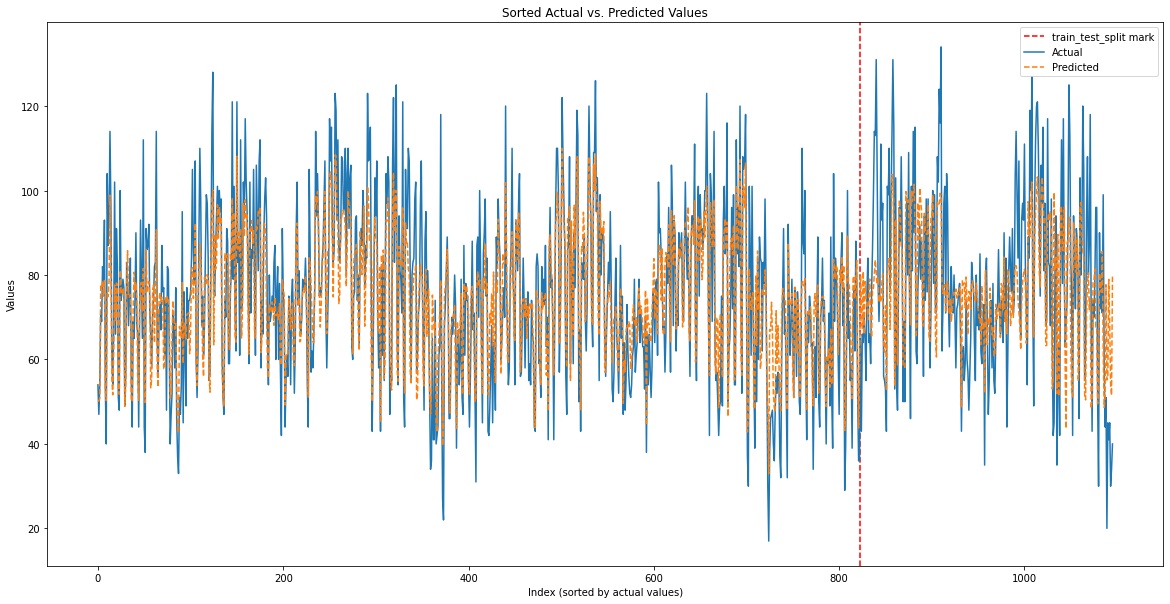

In [37]:
y_pred_all = regressor.predict(X_poly)

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({'Actual': y, 'Predicted': y_pred_all})

#Prepare a line to distinguish trainset & testset
train_test_split_mark = int(len(y) * 0.75)

# Create a line plot to compare sorted actual and predicted values
plt.figure(figsize=(20, 10))
plt.axvline(x=train_test_split_mark, color='r', linestyle='--', label='train_test_split mark')
plt.plot(results_df['Actual'].reset_index(drop=True), label='Actual')
plt.plot(results_df['Predicted'].reset_index(drop=True), label='Predicted', linestyle='--')
plt.xlabel('Index (sorted by actual values)')
plt.ylabel('Values')
plt.title('Sorted Actual vs. Predicted Values')
plt.legend()

plt.show()

Again, even after experimenting with 100 different values for lambda, we do not seem to be able to avoid overfitting. 

Do we get a better result if we drop the polynomial features? 
Unfortunately, with XGBoost it's not possible to add this as a parameter to our search grid. 
Instead we need to repeat all steps with the normal featureset: 

In [38]:
# As we are working with time-dependent data, it's important to sort our observations by date.
data = data.sort_values('Date', ascending=True) 

X = data.drop(['Number_of_accidents', 'Date'], axis=1)
y = data['Number_of_accidents']
column_names = X.columns

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Normalize the features
scaler = Normalizer()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=column_names)

# Clip values beyond a certain treshold. This avoids errors when fitting the model. 
X = X.clip(-1e11,1e11)


# Make sure not to shuffle our dataset, as this can cause data leakage.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

regressor=xgb.XGBRegressor(eval_metric='rmse')

# set up our search grid. For performance reasons, I dropped the learning rate from the grid. 
hyperparameter_grid = {
    'lambda': np.logspace(-2, 0, 100),
    }

# try out every combination of the above values
search = RandomizedSearchCV(regressor, hyperparameter_grid, cv=3).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_) 

The best hyperparameters are  {'lambda': 0.15556761439304723}


In [39]:
regressor=xgb.XGBRegressor(eta = 0.1,
                           gamma  = 0,
                           reg_lambda = search.best_params_["lambda"],
                           learning_rate = 0.05,
                           max_depth = 4,
                           eval_metric='rmsle')

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

# calculate the metrics
mse_dxgb2 = metrics.mean_squared_error(y_test, y_pred)
mae_dxgb2 = metrics.mean_absolute_error(y_test, y_pred)
r2_dxgb2 = metrics.r2_score(y_test, y_pred)

print('Mean Squared Error:', mse_dxgb2)
print('Mean Absolute Error:', mae_dxgb2)
print('R^2 Score:', r2_dxgb2)

Mean Squared Error: 277.9268419262676
Mean Absolute Error: 13.287337713868078
R^2 Score: 0.4268728016522132


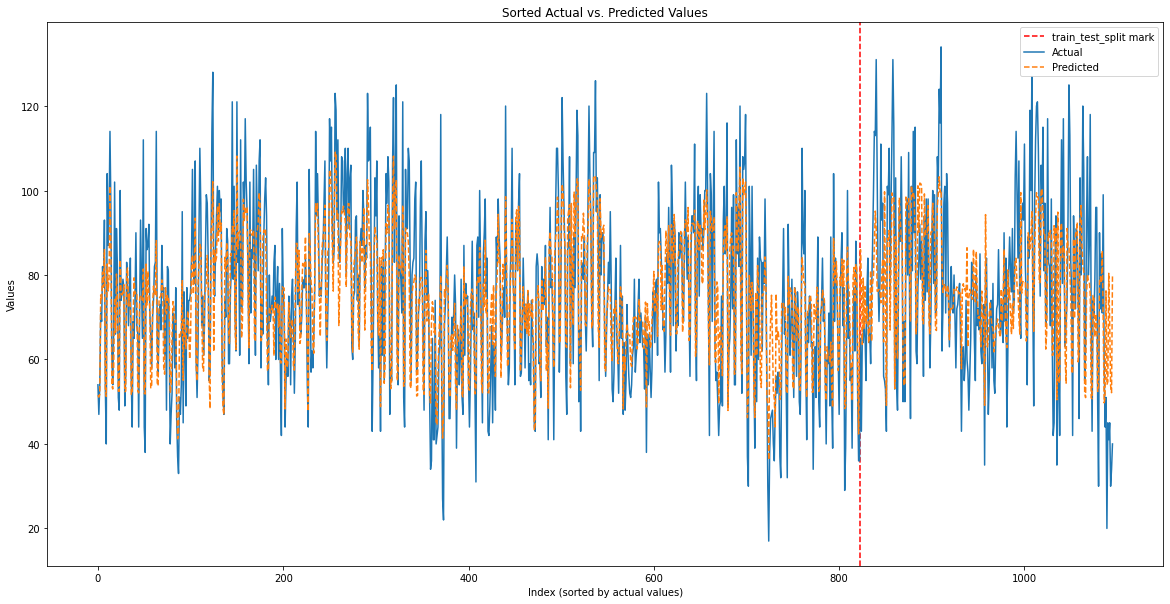

In [40]:
y_pred_all = regressor.predict(X)

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({'Actual': y, 'Predicted': y_pred_all})

#Prepare a line to distinguish trainset & testset
train_test_split_mark = int(len(y) * 0.75)

# Create a line plot to compare sorted actual and predicted values
plt.figure(figsize=(20, 10))
plt.axvline(x=train_test_split_mark, color='r', linestyle='--', label='train_test_split mark')
plt.plot(results_df['Actual'].reset_index(drop=True), label='Actual')
plt.plot(results_df['Predicted'].reset_index(drop=True), label='Predicted', linestyle='--')
plt.xlabel('Index (sorted by actual values)')
plt.ylabel('Values')
plt.title('Sorted Actual vs. Predicted Values')
plt.legend()

plt.show()

The performance has not improved. 
It also does not seem like we were able to avoid overfitting. 

In [41]:
#Evaluation of the training set: 

y_pred_train = regressor.predict(X_train)

# calculate the metrics
mse = metrics.mean_squared_error(y_train, y_pred_train)
mae = metrics.mean_absolute_error(y_train, y_pred_train)
r2 = metrics.r2_score(y_train, y_pred_train)

print('Mean Squared Error - training set:', mse)
print('Mean Absolute Error - training set:', mae)
print('R^2 Score - training set:', r2)

Mean Squared Error - training set: 115.67020038451871
Mean Absolute Error - training set: 8.520538042351568
R^2 Score - training set: 0.719475806196456


#### Conclusion

It may be better to stick to simpler models, for the following reasons: 

- Training time of more complex models may become an issue, especially when working with parameter grids and a very basic laptop
- Our target variable follows a normal distribution, suggesting that the correlation with our features is likely linear
- We are not able to increase the performance compared to our most basic linear model
- We need to avoid overfitting

### Basic Linear Regression with Rolling window 

Until now, we have used a normal train-test-split when training our data. 
For time-dependent data however, it may be better to use a rolling window. 

In [42]:

# as patterns repeat depending on the season, we will use a full year as our rolling window
window_size = 365
forecast_horizon = 1 

# As we are working with time-dependent data, it's important to sort our observations by date.
data = data.sort_values('Date', ascending=True) 
X = data.drop(['Number_of_accidents', 'Date'], axis=1)
y = data['Number_of_accidents']
feature_names = X.columns

# Scale the features
# This is generally not needed for simple linear regression, but will make it easier to analyze coefficients
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Normalize the features
scaler = Normalizer()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=feature_names)


In [43]:
lr = LinearRegression()
predictions = []

for i in range(window_size, len(data) - forecast_horizon):
    X_train = X.iloc[i-window_size:i]  # Defines end of rolling window
    X_test = X.iloc[i:i+forecast_horizon]  # Defines prediction horizon
    y_train = y.iloc[i-window_size:i]  # Defines end of rolling window
    y_test = y.iloc[i:i+forecast_horizon]  # Defines prediction horizon
    
    # Define and fit model
    lr.fit(X_train, y_train)
    
    # Predict and store predictions
    prediction = lr.predict(X_test)
    predictions.append(prediction[0])

In [44]:
# actual values corresponding to the predictions
y_true = data['Number_of_accidents'][window_size:-1].values

# calculate the metrics
mse_drw = metrics.mean_squared_error(y_true, predictions)
mae_drw = metrics.mean_absolute_error(y_true, predictions)
r2_drw = metrics.r2_score(y_true, predictions)

print('Mean Squared Error:', mse_drw)
print('Mean Absolute Error:', mae_drw)
print('R^2 Score:', r2_drw)

Mean Squared Error: 237.21773186321906
Mean Absolute Error: 12.255297350739037
R^2 Score: 0.4612648445949209


The results are very similar to our original regression model. 
Let's see if the plot is comparable too: 

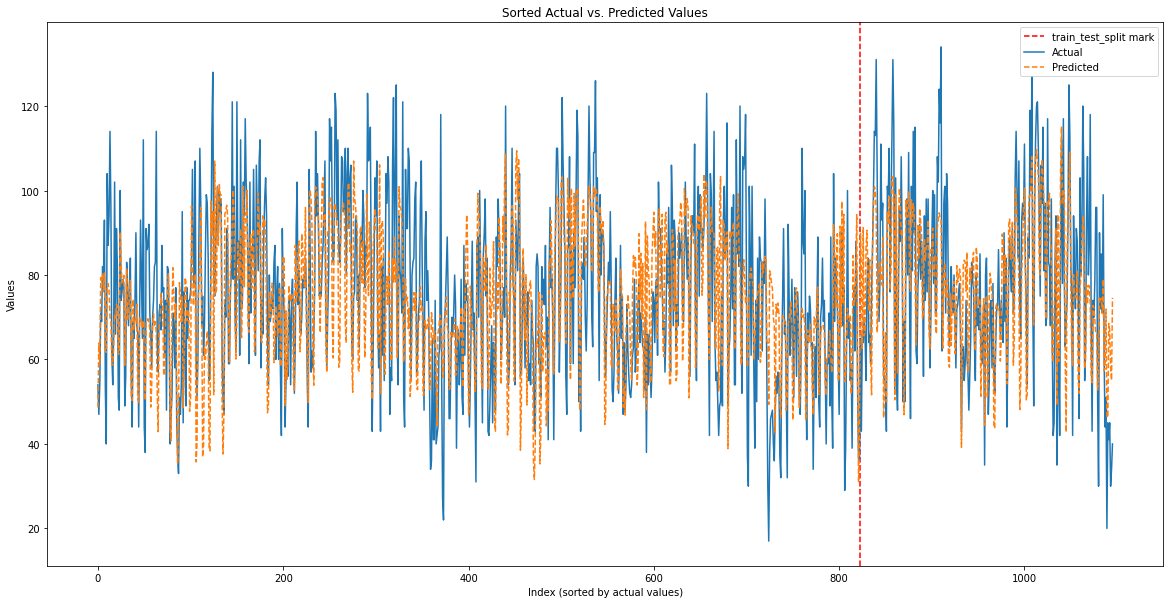

In [45]:
y_pred_all = lr.predict(X)

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({'Actual': y, 'Predicted': y_pred_all})

#Prepare a line to distinguish trainset & testset
train_test_split_mark = int(len(y) * 0.75)

# Create a line plot to compare sorted actual and predicted values
plt.figure(figsize=(20, 10))
plt.axvline(x=train_test_split_mark, color='r', linestyle='--', label='train_test_split mark')
plt.plot(results_df['Actual'].reset_index(drop=True), label='Actual')
plt.plot(results_df['Predicted'].reset_index(drop=True), label='Predicted', linestyle='--')
plt.xlabel('Index (sorted by actual values)')
plt.ylabel('Values')
plt.title('Sorted Actual vs. Predicted Values')
plt.legend()

plt.show()

Conclusion: there seem to be no improvement over our original LR model

### Feature importances

As the previous model is probably as good as it gets for now, let's see what the most important features are in the dataset:

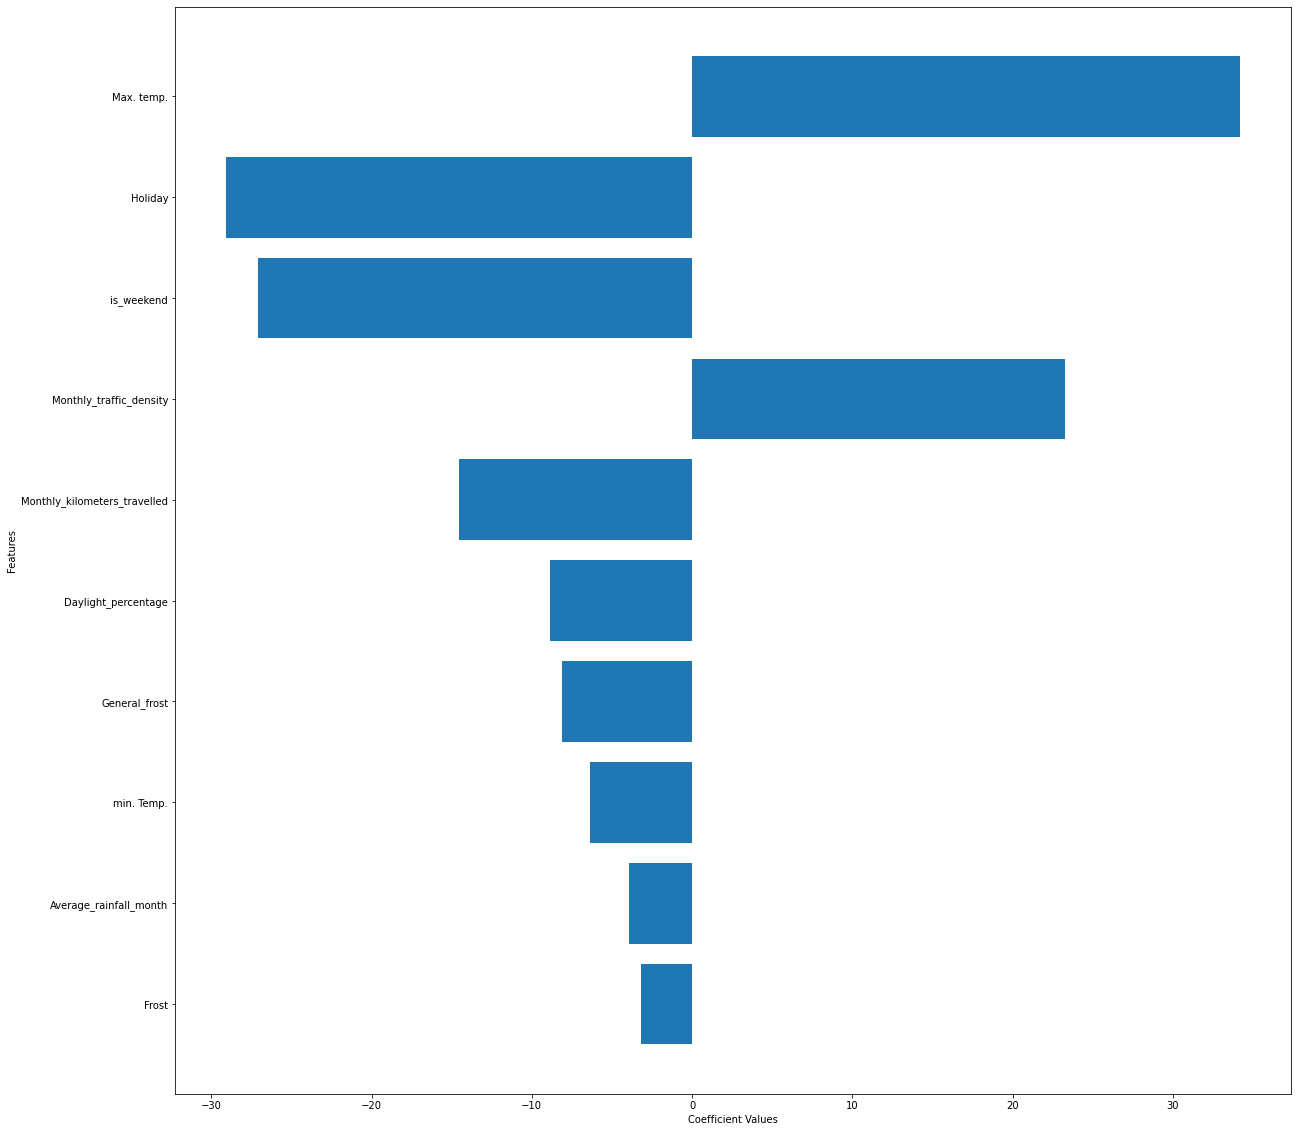

In [46]:
# Access the coefficient values
coefficients = lr.coef_
intercept = lr.intercept_

# Sort coefficients and feature names based on absolute coefficient values
sorted_coefficients = sorted(zip(coefficients, feature_names), key=lambda x: abs(x[0]))
sorted_coefficients = list(zip(*sorted_coefficients))
sorted_coefficients, sorted_feature_names = sorted_coefficients[0], sorted_coefficients[1]

# Plot the sorted feature importance horizontally
plt.figure(figsize=(20, 20))
plt.barh(range(len(sorted_coefficients)), sorted_coefficients)
plt.yticks(range(len(sorted_coefficients)), sorted_feature_names)
plt.xlabel('Coefficient Values')
plt.ylabel('Features')
plt.show()


Unsurprisingly, **Holiday** and **is_weekend** are at the top of the list. 

Any indicator that may signal how busy traffic is going to be, seems to perform well. 

Strangely, **Max. temp** seems to be the most important feature according to our model, while **min. Temp** makes little difference. 

The correlation heatmap (see Part 4) does not suggest this. 

It's hard to find a logical explanation for this fact. 

Does excluding this feature decrease the performance of our model? 

In [47]:
# Sort our observations by date.
data = data.sort_values('Date', ascending=True) 

# this time, also drop Max.temp from the featureset
X = data.drop(['Number_of_accidents', 'Date', 'Max. temp.'], axis=1)
y = data['Number_of_accidents']

# Make sure not to shuffle our dataset, as this can cause data leakage.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# calculate metrics
mse = metrics.mean_squared_error(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)
print('R^2 Score:', r2)

Mean Squared Error: 281.38850390206585
Mean Absolute Error: 13.535473662003179
R^2 Score: 0.41973433090910084


The model indeed performs quite a bit worse without this information. The R2-score drops by 0.06(!) 

The main reason I can think of, is that in general roads will be busier when the weather is nicer.

We don't have a good way to check this, because the traffic density-feature is limited to monthly averages. 

This might be interesting for further analysis. 

## Part 6: Machine Learning - Prescriptive Analytics

### Time-series forecasting with Meta's Prophet

In Part 6, we will focus mainly on creating a model that has predictive capabilities. 
These means that we can no longer rely on any features that will not be known in advance. 

Before constructing, such a dataset, let's see if we can use Meta's Prophet library to make a simple forecasting model. 
Prophet is an easy-to-use forecasting models that has many built-in capabilities, such as seasonality detection, flexibility in handling missing datapoints and changepoint identification. 
Furthermore, it only takes the date + target variable as input. 

Let's first try this without setting any parameters. 

In [48]:
# Sort our observations by date.
data = data.sort_values('Date', ascending=True) 

X = data['Date']
y = data['Number_of_accidents']

# Make sure not to shuffle our dataset, as this can cause data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

# Combine X_train and y_train into a single DataFrame
train = pd.DataFrame({'ds': X_train, 'y': y_train})

X_test = pd.DataFrame({'ds': X_test})
y_test = pd.DataFrame({'y': y_test})

m = Prophet()
m.fit(train)

y_pred = m.predict(X_test)
y_pred = y_pred['yhat']

y_pred = pd.DataFrame({'y': y_pred})

# calculate the metrics
mse_pp = metrics.mean_squared_error(y_test, y_pred)
mae_pp = metrics.mean_absolute_error(y_test, y_pred)
r2_pp = metrics.r2_score(y_test, y_pred)

print('Mean Squared Error:', mse_pp)
print('Mean Absolute Error:', mae_pp)
print('R^2 Score:', r2_pp)

11:05:50 - cmdstanpy - INFO - Chain [1] start processing
11:05:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error: 312.64887249878774
Mean Absolute Error: 13.630035825442095
R^2 Score: 0.35527072117286884


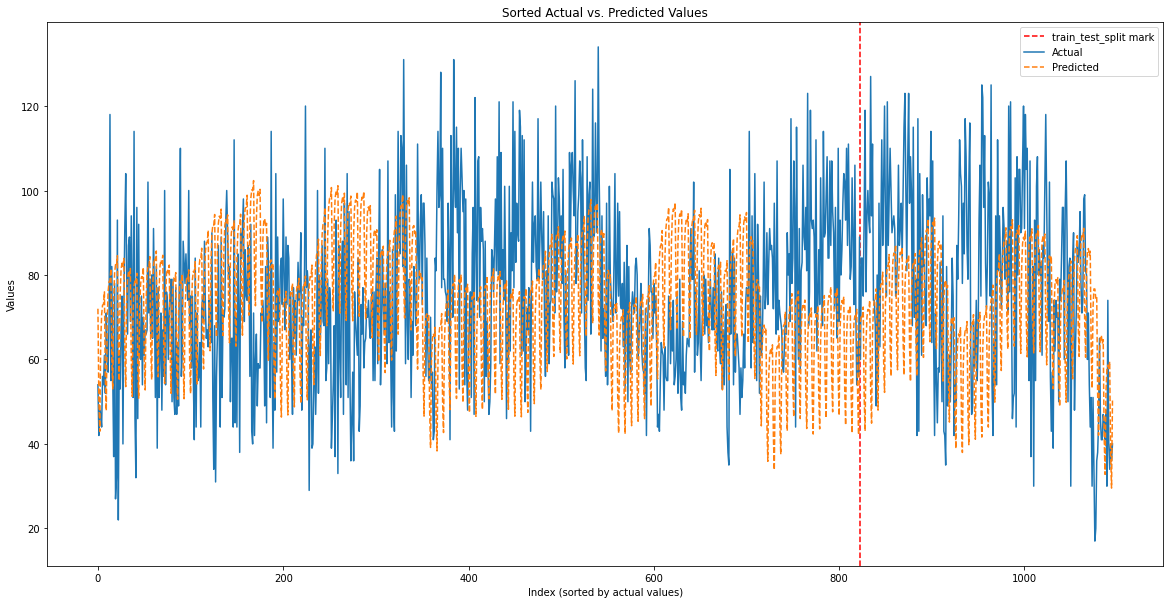

In [49]:
X = pd.DataFrame({'ds': X})
prophet_results = m.predict(X)
y_pred_all = prophet_results['yhat']

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({'Actual': y, 'Predicted': y_pred_all})

#Prepare a line to distinguish trainset & testset
train_test_split_mark = int(len(y) * 0.75)

# Create a line plot to compare sorted actual and predicted values
plt.figure(figsize=(20, 10))
plt.axvline(x=train_test_split_mark, color='r', linestyle='--', label='train_test_split mark')
plt.plot(results_df['Actual'].reset_index(drop=True), label='Actual')
plt.plot(results_df['Predicted'].reset_index(drop=True), label='Predicted', linestyle='--')
plt.xlabel('Index (sorted by actual values)')
plt.ylabel('Values')
plt.title('Sorted Actual vs. Predicted Values')
plt.legend()

plt.show()

On first sight this does not look like a very good prediction. 
The R2-score has also dropped significantly compared to our previous models. 

When zooming in on our testset, we see quite a big gap between predicted & actual values

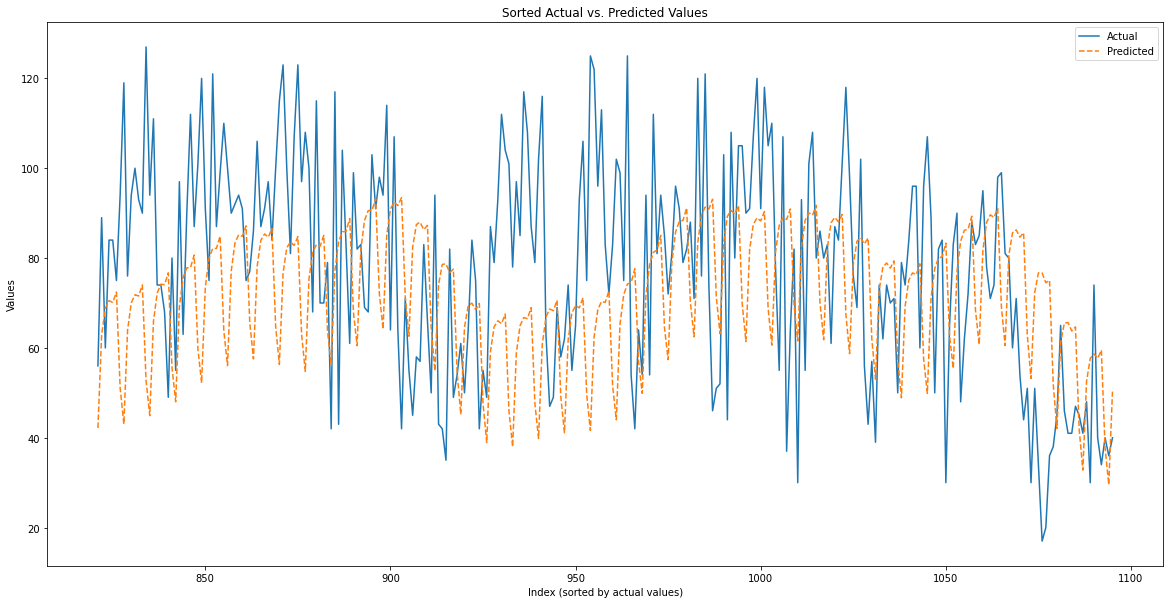

In [50]:
results_testset = results_df[821:1096]

# Create a line plot to compare sorted actual and predicted values
plt.figure(figsize=(20, 10))
plt.plot(results_testset['Actual'], label='Actual')
plt.plot(results_testset['Predicted'], label='Predicted', linestyle='--')
plt.xlabel('Index (sorted by actual values)')
plt.ylabel('Values')
plt.title('Sorted Actual vs. Predicted Values')
plt.legend()

plt.show()

It seems that the model often seems to underestimate the number of accidents. 
Let's check if that intuition is correct: 

In [51]:
# Calculate the average difference between actual & predicted values
sum_actual = results_testset['Actual'].sum()
sum_predicted = results_testset['Predicted'].sum()
test_len = len(results_testset) 

total = (sum_actual - sum_predicted) / test_len

print('Average difference between actual & predicted values:', total)

Average difference between actual & predicted values: 6.303612868365268


Indeed, while the mean number of accidents per day is +/- 75 over the entire dataset, prophet seems to underestimate this number by on average 6.3

Prophet does not only predict single values, it can also output predictions as a range. 
Let's add the upper and lower range to the plot: 

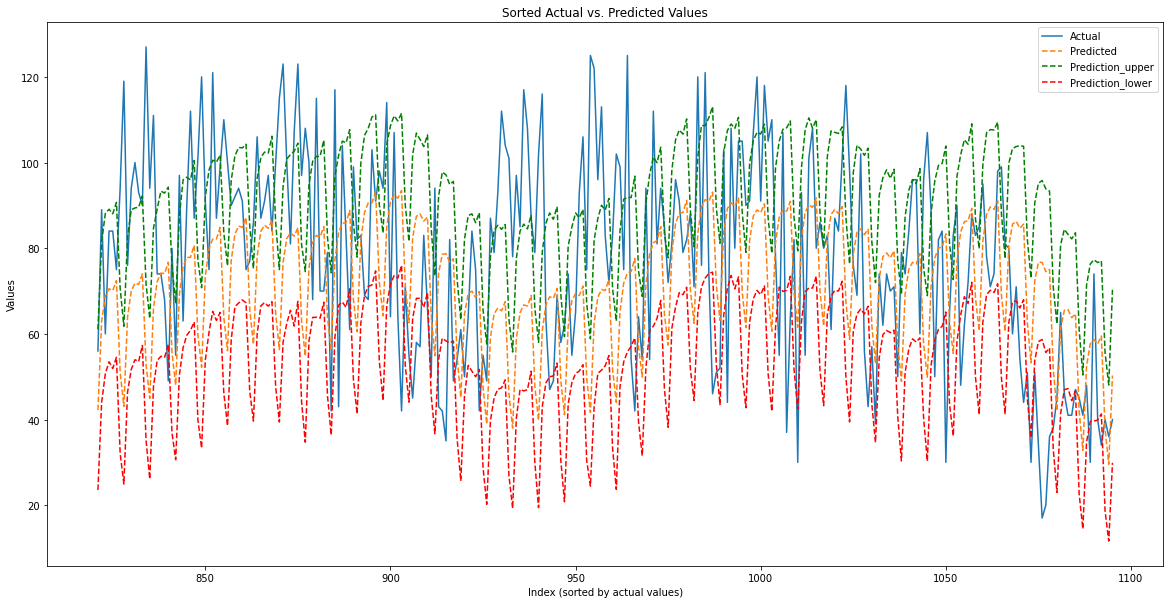

In [52]:
y_pred_all = prophet_results['yhat']
y_pred_lower = prophet_results['yhat_lower']
y_pred_upper = prophet_results['yhat_upper']

results_df = pd.DataFrame({'Actual': y, 'Predicted': y_pred_all, 'Prediction_upper': y_pred_upper, 'Prediction_lower': y_pred_lower})

results_testset = results_df[821:1096]

# Create a line plot to compare sorted actual and predicted values
plt.figure(figsize=(20, 10))
plt.plot(results_testset['Actual'], label='Actual')
plt.plot(results_testset['Predicted'], label='Predicted', linestyle='--')
plt.plot(results_testset['Prediction_upper'], label='Prediction_upper', color='green', linestyle='--')
plt.plot(results_testset['Prediction_lower'], label='Prediction_lower', color='red', linestyle='--')
plt.xlabel('Index (sorted by actual values)')
plt.ylabel('Values')
plt.title('Sorted Actual vs. Predicted Values')
plt.legend()

plt.show()

This also does not look very promising. Outliers still frequently fall outside of the predicted range. 
None of the predicted curves seem to line up very well with our actual target variable. 

**Conclusion:** without features, it seems like the prophet-model performs a lot worse than our previous models. 

### Linear Regression with Date-related Features

As our basic linear regression model has so far given the best results, it might be interesting to see how it performs if we drop all features that are not known in advance. 

To make optimal use of our data, we will also add a few features that can be derived directly from our dates: 

- Season: categorical features is_summer, is_spring, is_winter & is_autumn

(we will use the meteorological season for simplicity reasons, as they always start at the beginning of a month)

- Month: categorical feature for the year of the month


In [53]:
# get the feature names
column_names = data.columns
print(column_names) 

Index(['Number_of_accidents', 'Average_rainfall_month', 'Max. temp.',
       'min. Temp.', 'Frost', 'General_frost', 'Monthly_traffic_density',
       'Monthly_kilometers_travelled', 'Daylight_percentage', 'Holiday',
       'is_weekend', 'Date'],
      dtype='object')


In [54]:
# isolate only the features that are relevant for forecasting

data_fc = data[['Number_of_accidents','Daylight_percentage', 'Holiday',
       'is_weekend', 'Date']].copy()

data_fc.head(5)

Number_of_accidents  Daylight_percentage  Holiday  is_weekend       Date
0                  54.0             0.327778      1.0         0.0 2016-01-01
3                  47.0             0.328472      0.0         1.0 2016-01-02
6                  54.0             0.329167      0.0         1.0 2016-01-03
9                  71.0             0.329861      0.0         0.0 2016-01-04
12                 69.0             0.330556      0.0         0.0 2016-01-05

In [55]:
# add the feature 'month' to the dataset: 
data_fc['month_of_year'] = data_fc['Date'].dt.month 

# add the feature 'season' to the dataset

#define a function deriving the metereological season from the "month" feature
def get_season(month):
    if month in [1, 2, 12]:
        season = 'winter'
    elif month in [3, 4, 5]:
        season = 'spring'
    elif month in [6, 7, 8]:
        season = 'summer'
    else:
        season = 'autumn'
        
    return season

# Add the season to the dataset
data_fc['Season'] = data_fc['month_of_year'].apply(get_season)

data_fc.head(5)

Number_of_accidents  Daylight_percentage  Holiday  is_weekend       Date  \
0                  54.0             0.327778      1.0         0.0 2016-01-01   
3                  47.0             0.328472      0.0         1.0 2016-01-02   
6                  54.0             0.329167      0.0         1.0 2016-01-03   
9                  71.0             0.329861      0.0         0.0 2016-01-04   
12                 69.0             0.330556      0.0         0.0 2016-01-05   

    month_of_year  Season  
0               1  winter  
3               1  winter  
6               1  winter  
9               1  winter  
12              1  winter

In [56]:
# turn the month_of_year into a categorical feature

month_encoded = pd.get_dummies(data_fc['month_of_year'], prefix='Month_of_year')
month_encoded = month_encoded.astype(int)
data_fc = pd.concat([data_fc, month_encoded], axis=1)

data_fc = data_fc.drop('month_of_year', axis=1)

# turn "season" into a categorical feature

seasons_encoded = pd.get_dummies(data_fc['Season'], prefix='Season')
seasons_encoded = seasons_encoded.astype(int)
data_fc = pd.concat([data_fc, seasons_encoded], axis=1)

data_fc = data_fc.drop('Season', axis=1)

data_fc.head(5)

Number_of_accidents  Daylight_percentage  Holiday  is_weekend       Date  \
0                  54.0             0.327778      1.0         0.0 2016-01-01   
3                  47.0             0.328472      0.0         1.0 2016-01-02   
6                  54.0             0.329167      0.0         1.0 2016-01-03   
9                  71.0             0.329861      0.0         0.0 2016-01-04   
12                 69.0             0.330556      0.0         0.0 2016-01-05   

    Month_of_year_1  Month_of_year_2  Month_of_year_3  Month_of_year_4  \
0                 1                0                0                0   
3                 1                0                0                0   
6                 1                0                0                0   
9                 1                0                0                0   
12                1                0                0                0   

    Month_of_year_5  ...  Month_of_year_7  Month_of_year_8  Month_of_year_9  \
0                 0  ...                0                0                0   
3                 0  ...                0                0                0   
6                 0  ...                0                0                0   
9                 0  ...                0                0                0   
12                0  ...                0                0                0   

    Month_of_year_10  Month_of_year_11  Month_of_year_12  Season_autumn  \
0                  0                 0                 0              0   
3                  0                 0                 0              0   
6                  0                 0                 0              0   
9                  0                 0                 0              0   
12                 0                 0                 0              0   

    Season_spring  Season_summer  Season_winter  
0               0              0              1  
3               0              0              1  
6               0              0              1  
9               0              0              1  
12              0              0              1  

[5 rows x 21 columns]

* note: because our new features are highly correlated with each other, we run the risk of **Multicollinearity**. 
For this reason, we will have to add regularization terms. 

In [57]:
# sort our observations by date.
data_fc = data_fc.sort_values('Date', ascending=True) 

X = data_fc.drop(['Number_of_accidents', 'Date'], axis=1)
y = data_fc['Number_of_accidents']

feature_names = X.columns

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Normalize the features
scaler = Normalizer()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=feature_names)

# Make sure not to shuffle our dataset, as this can cause data leakage.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)



# Define the grid & train the model
model = Ridge()

grid = {
    'alpha': np.logspace(-2, 1, 200)
}
grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

# Make predictions on the testset, using the best estimator

# Predict using the model with the best parameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test) 


# calculate the metrics
mse_plr = metrics.mean_squared_error(y_test, y_pred)
mae_plr = metrics.mean_absolute_error(y_test, y_pred)
r2_plr = metrics.r2_score(y_test, y_pred)

print('Mean Squared Error:', mse_plr)
print('Mean Absolute Error:', mae_plr)
print('R^2 Score:', r2_plr)

Mean Squared Error: 279.79197885034733
Mean Absolute Error: 13.139468787813675
R^2 Score: 0.4230266071197816


plot to compare predicted/actual values: 

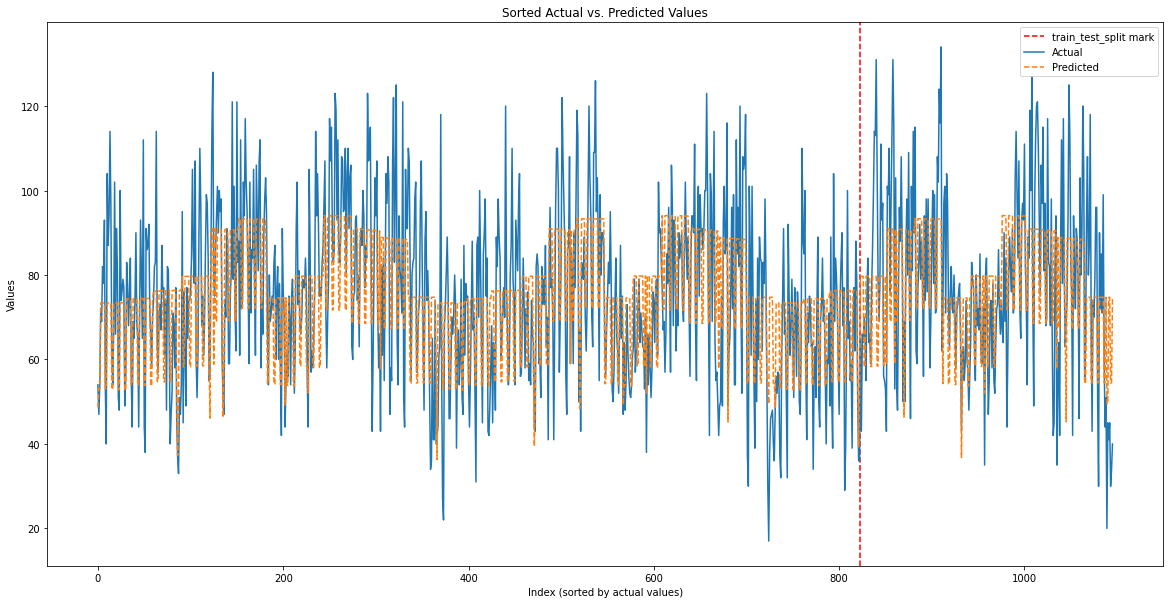

In [58]:
y_pred_all = best_model.predict(X)

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({'Actual': y, 'Predicted': y_pred_all})

#Prepare a line to distinguish trainset & testset
train_test_split_mark = int(len(y) * 0.75)

# Create a line plot to compare sorted actual and predicted values
plt.figure(figsize=(20, 10))
plt.axvline(x=train_test_split_mark, color='r', linestyle='--', label='train_test_split mark')
plt.plot(results_df['Actual'].reset_index(drop=True), label='Actual')
plt.plot(results_df['Predicted'].reset_index(drop=True), label='Predicted', linestyle='--')
plt.xlabel('Index (sorted by actual values)')
plt.ylabel('Values')
plt.title('Sorted Actual vs. Predicted Values')
plt.legend()

plt.show()

plot only displaying the test set: 

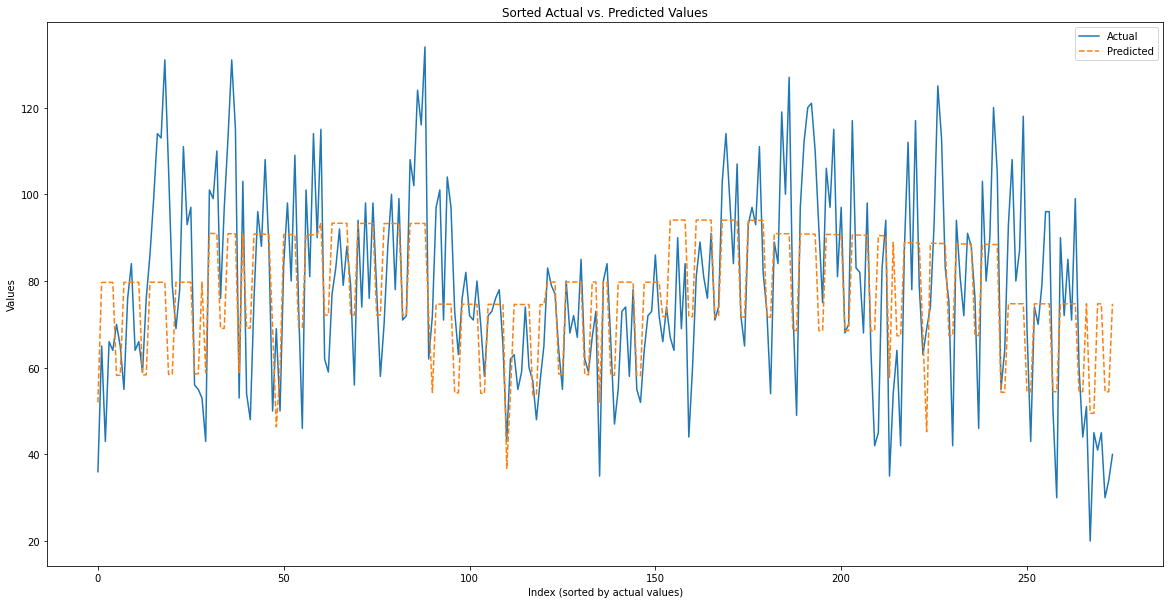

In [59]:
y_pred_test = best_model.predict(X[int(len(y) * 0.75):])

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})

# Create a line plot to compare sorted actual and predicted values
plt.figure(figsize=(20, 10))
plt.plot(results_df['Actual'].reset_index(drop=True), label='Actual')
plt.plot(results_df['Predicted'].reset_index(drop=True), label='Predicted', linestyle='--')
plt.xlabel('Index (sorted by actual values)')
plt.ylabel('Values')
plt.title('Sorted Actual vs. Predicted Values')
plt.legend()

plt.show()

On average, our model performs worse without the added weather data & traffic statistics. 

The R2-score dropped from 0.48 to 0.42

The curve displaying our predicted values is a lot more flattened out, when compared to our linear model in chapter 5. 

Below I calculated standard deviation, range, variance and mean absolute deviation 

for both our test set + corresponding predicted values. 

In [60]:
# For y_test Series
print("Metrics for y_test Series:\n")

# Standard Deviation
std_dev = y_test.std()
print(f"Standard Deviation: {std_dev}")

# Range
range_value = y_test.max() - y_test.min()
print(f"Range: {range_value}")

# Variance
variance = y_test.var()
print(f"Variance: {variance}")

# Mean Absolute Deviation
mad = abs(y_test - y_test.mean()).mean()
print(f"Mean Absolute Deviation: {mad}")

print("-------------------------------")

# For y_pred_test Series
print("Metrics for y_pred_test Series:\n")

# Standard Deviation
std_dev = y_pred_test.std()
print(f"Standard Deviation: {std_dev}")

# Range
range_value = y_pred_test.max() - y_pred_test.min()
print(f"Range: {range_value}")

# Variance
variance = y_pred_test.var()
print(f"Variance: {variance}")

# Mean Absolute Deviation
mad = abs(y_pred_test - y_pred_test.mean()).mean()
print(f"Mean Absolute Deviation: {mad}")



Metrics for y_test Series:

Standard Deviation: 22.061431788217842
Range: 114.0
Variance: 486.7067725461887
Mean Absolute Deviation: 17.64654483456764
-------------------------------
Metrics for y_pred_test Series:

Standard Deviation: 13.141322528678273
Range: 57.292390283323876
Variance: 172.6943578027471
Mean Absolute Deviation: 10.890665283892599


You can see clearly that the predicted values tend to be a lot closer to the mean. 
This suggest that your model might not be capturing the extremes (minimum and maximum values) as effectively as the more average cases.


**Feature Importances**

In [61]:
# create a table with all features and their coefficients
coef_df = pd.DataFrame({'feature': X.columns, 'coef': best_model.coef_}) 

# sort the table by feature importance (absolute value of the coefficients)
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False)

coef_df.head(20)

feature       coef   abs_coef
2            is_weekend -41.526061  41.526061
1               Holiday -31.019151  31.019151
8       Month_of_year_6  12.762617  12.762617
7       Month_of_year_5   9.575004   9.575004
9       Month_of_year_7  -9.448218   9.448218
15        Season_autumn   8.496342   8.496342
18        Season_winter  -7.944832   7.944832
11      Month_of_year_9   7.306238   7.306238
5       Month_of_year_3  -6.997172   6.997172
3       Month_of_year_1  -5.085726   5.085726
4       Month_of_year_2  -3.910519   3.910519
12     Month_of_year_10   3.790009   3.790009
14     Month_of_year_12  -3.460832   3.460832
10      Month_of_year_8  -3.422517   3.422517
6       Month_of_year_4  -3.214759   3.214759
13     Month_of_year_11   2.231070   2.231070
0   Daylight_percentage   1.107970   1.107970
16        Season_spring  -0.378376   0.378376
17        Season_summer  -0.190603   0.190603

Both Month_of_year and Season seem to be relevant factors, probably because they help indicate expected traffic density. 
For example, in Part 4 - Exploratory analysis, we noticed that June will on average have the biggest number of accidents. 

For me, it's an open question wether adding the "Season"-feature was a good idea. 

Especially when using the meteorological seasons, as they perfectly line up with certain months of the year. 

Dropping the seasons could give more insight in the importance of the Month_of_year. 

As of now, it's more difficult to assess this, due to the fact that this correlates with the season. 

For example, the month of September shows a peak in traffic accidents, similar to June, yet it has a much smaller coefficient than June. 

This is likely due to the fact that part of its importance is alreay weighted under the "Season_autumn"-feature.

On the other hand, dropping this feature will probably have a negative impact on the predictive power of our model, which is the main goal of this chapter. 

### Part 6: Concluding Remarks

Now how did our models perform and how did they compare to eachother? 

Below is a bar chart for every model used and the main KPI's: 

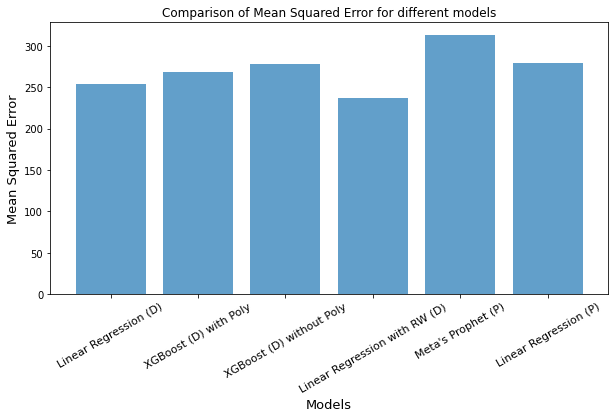

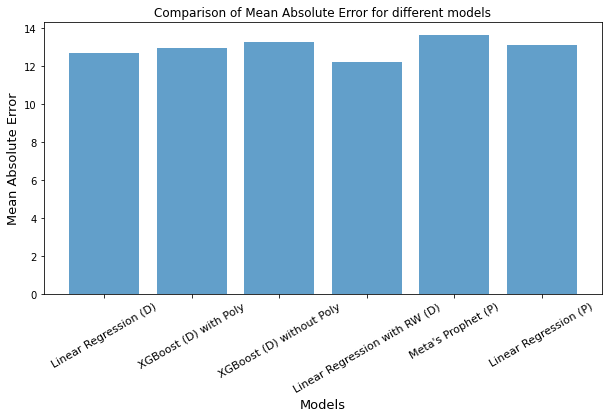

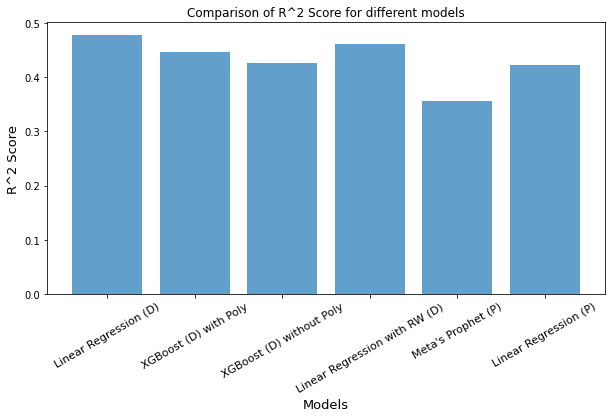

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your MSE, MAE, and R^2 values for each model are defined

# Define a list of model names
models = ['Linear Regression (D)', 'XGBoost (D) with Poly', 'XGBoost (D) without Poly', 
          'Linear Regression with RW (D)', "Meta's Prophet (P)", 'Linear Regression (P)']

# Define a list of metrics for each model
mse = [mse_dlr, mse_dxgb, mse_dxgb2, mse_drw, mse_pp, mse_plr]
mae = [mae_dlr, mae_dxgb, mae_dxgb2, mae_drw, mae_pp, mae_plr]
r2 = [r2_dlr, r2_dxgb, r2_dxgb2, r2_drw, r2_pp, r2_plr]

# Define a function to create a bar plot
def plot_bar(models, metrics, metric_name):
    index = np.arange(len(models))
    plt.figure(figsize=(10,5))
    plt.bar(index, metrics, align='center', alpha=0.7)
    plt.xlabel('Models', fontsize=13)
    plt.ylabel(metric_name, fontsize=13)
    plt.xticks(index, models, fontsize=11, rotation=30)
    plt.title(f'Comparison of {metric_name} for different models')
    plt.show()

# Call the function to plot bar chart for MSE
plot_bar(models, mse, 'Mean Squared Error')

# Call the function to plot bar chart for MAE
plot_bar(models, mae, 'Mean Absolute Error')

# Call the function to plot bar chart for R^2
plot_bar(models, r2, 'R^2 Score')


This was very educational exercise, but the models that we constructed have some clear limitations. 

1. Model Limitations

It may be useful to use some more techniques that are specific to forecasting, such as analyzing cycles, 
seasonality & trends. 

2. Data limitations 

First, I was only able to get data on 3 different years. A bigger sample size might help in spotting recurring patterns. 

Second, the number of features was fairly limited. 

Possible future feature additions:

- Enhanced date-related data, for example the addition of school holidays, labour strikes...
- (only for descriptive analysis) Detailed weather data, including mist, risk of aquaplaning, snow... 
- Big events that increase the chance of intoxicated driving like music festivals, new years eve and big sports events.

Thirdly, the features that I do have can be improved aswell. 
For a number of features, like the average rainfall, I was limited to a monthly average. A daily average would probably yield way better results. 

It could also help to make the data more location-specific. For now, I summed up all accidents that occurred in Flanders + Brussels, but it would probably help to add location categories (provinces, highways...) to my dataset. 



## Data sources: 

Data on traffic volume: 
http://indicatoren.verkeerscentrum.be/vc.indicators.web.gui/indicator/index#/presentation-tab-table

Weather reports: 
https://klimaat.vmm.be/open-data

List of traffic accidents: 
https://statbel.fgov.be/nl/themas/mobiliteit/verkeer/verkeersongevallen
